# Imports

In [1]:
%load_ext autoreload

In [2]:
import numpy as np
from src import *

%autoreload 2

# Signal

In [6]:
# Signal width
N = 128

# Sparse signal parameters
sparse_range = (-6, 6)
density = 0.005

# Smooth signal parameters
smooth_amplitude = 2
sigmas_range = (2e-2, 2e-1)
nb_gaussian = int(0.5 * N)

# Seed
seed = 42

# Noise (in dB)
psnrdb = 20


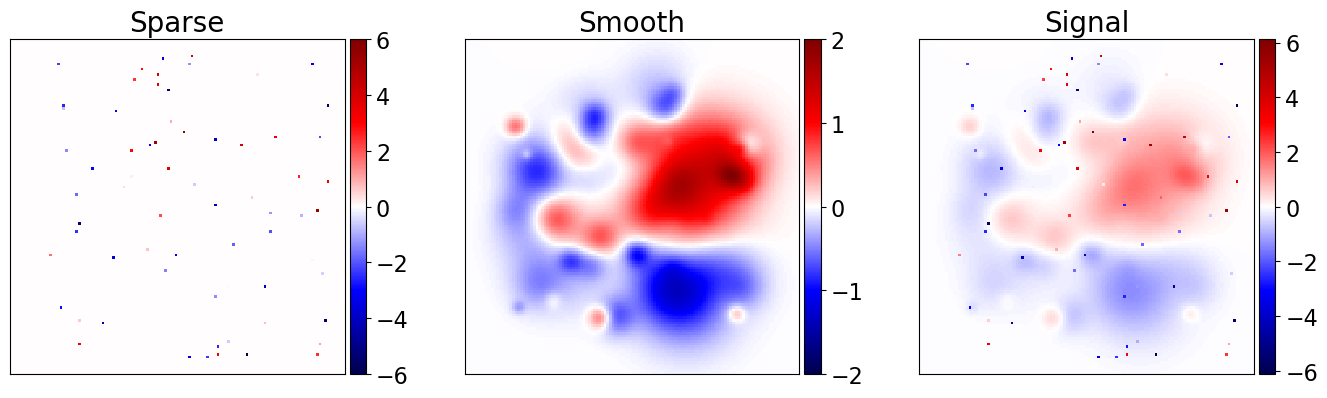

In [7]:
sparse_signal = compute_sparse(N, sparse_range, density, seed)
smooth_signal = compute_smooth(N, smooth_amplitude, sigmas_range, nb_gaussian, seed)

signal = sparse_signal + smooth_signal

plot_signal(sparse_signal, smooth_signal);

# Operator $\phi$

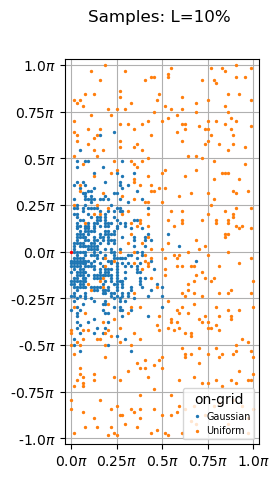

In [8]:
L = 0.1
theta = 0.5
op = NuFFT(N, L, theta, on_grid=True, seed=seed)

x0 = signal.reshape(-1)
y0 = op(x0)

y = compute_y(y0, psnrdb)

op.plot_samples()

# Solver

In [9]:
# Loss weights
lambda1 = 1e-1
lambda2 = 5e-2

# Use Laplacian ?
laplacian = True

### Coupled

In [10]:
coupled = True

start_coupled = time.time()
(x1_coupled, x2_coupled), t_coupled = solve(y, op, lambda1, lambda2, coupled, laplacian)
total_t_coupled = time.time() - start_coupled

Coupled
INFO -- [2024-03-05 12:11:00.365392] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO -- [2024-03-05 12:11:01.715557] Iteration 13
	iteration: 13
	N_iter: 14.0
	RelError[x]: 5.343974310842805e-05
INFO -- [2024-03-05 12:11:01.717108] Stopping Criterion satisfied -> END


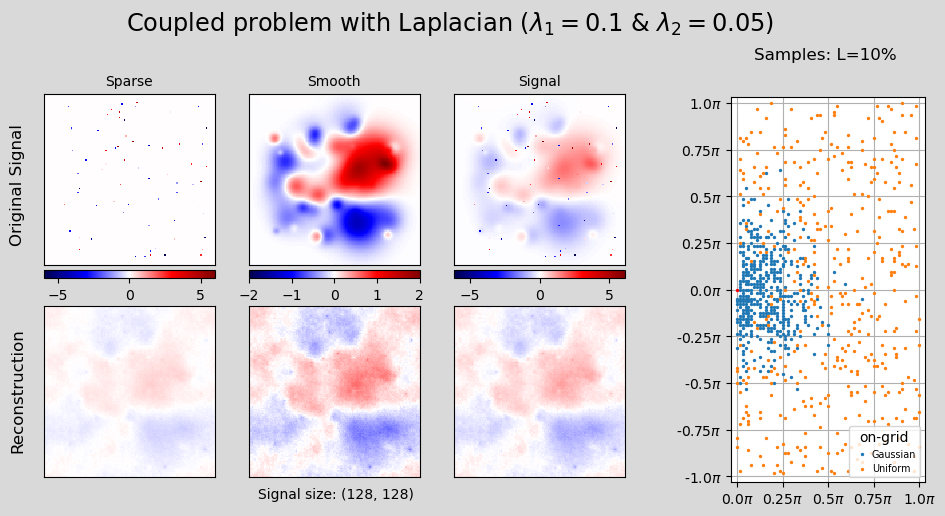

Button(description='SAVE', style=ButtonStyle())

Output()

In [12]:
sparse_rcstr_coupled, smooth_rcstr_coupled, signal_rcstr_coupled = map(
    lambda x: x.reshape((N,N)), (x1_coupled, x2_coupled, x1_coupled + x2_coupled)
)

fig = plot_results(
    [sparse_signal, smooth_signal],
    [sparse_rcstr_coupled, smooth_rcstr_coupled],
    lambda1,
    lambda2,
    op,
    coupled,
    laplacian
)

save_widget(fig, lambda1, lambda2, op, psnrdb, coupled)

### Decoupled

In [13]:
coupled = False

start_decoupled = time.time()
(x1_decoupled, x2_decoupled), t_decoupled = solve(y, op, lambda1, lambda2, coupled, laplacian)
total_t_decoupled = time.time() - start_decoupled

Decoupled
Co-Gram Identity
INFO -- [2024-03-05 12:11:20.592038] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO -- [2024-03-05 12:11:29.713310] Iteration 276
	iteration: 276
	N_iter: 277.0
	RelError[x]: 9.84914252236328e-05
INFO -- [2024-03-05 12:11:29.716661] Stopping Criterion satisfied -> END


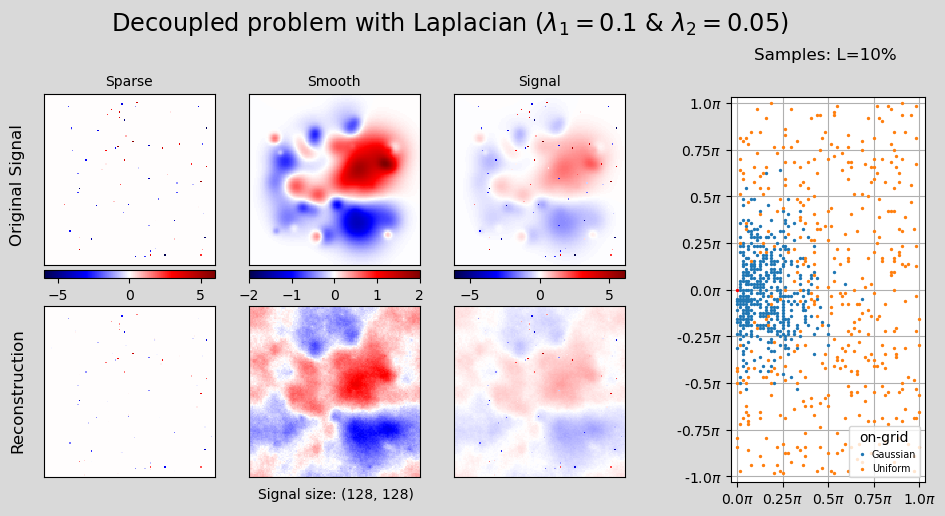

Button(description='SAVE', style=ButtonStyle())

Output()

In [14]:
sparse_rcstr_decoupled, smooth_rcstr_decoupled, signal_rcstr_decoupled = map(
    lambda x: x.reshape((N,N)), (x1_decoupled, x2_decoupled, x1_decoupled + x2_decoupled)
)

fig = plot_results(
    [sparse_signal, smooth_signal],
    [sparse_rcstr_decoupled, smooth_rcstr_decoupled],
    lambda1,
    lambda2,
    op,
    coupled,
    laplacian
)

save_widget(fig, lambda1, lambda2, op, psnrdb, coupled)

# Comparison

In [15]:
if laplacian : 
    laplacian_op = Laplacian((N, N), mode="wrap")

In [16]:
approaches = ["Coupled", "Decoupled"]
data_sets = [
    (sparse_rcstr_coupled, smooth_rcstr_coupled, t_coupled, total_t_coupled),
    (sparse_rcstr_decoupled, smooth_rcstr_decoupled, t_decoupled, total_t_decoupled),
]

for approach, (sparse_rcstr, smooth_rcstr, t, total_t) in zip(approaches, data_sets):
    print(f"{approach} Approach")

    data_fidelity, L2, L1, = objective_func(
        op,
        laplacian_op,
        y,
        sparse_rcstr,
        smooth_rcstr,
        lambda1,
        lambda2,
    )

    print(
        f"  Cost:  {data_fidelity+L2+L1:.0f}\n" +   
        f"    - Data fidelity: {data_fidelity:.0f}\n"+   
        f"    - L2: {L2:.0f} \n"+  
        f"    - L1: {L1:.0f}" 
    )
    print(f"  Time [s]: \n" +
        f"    - With preprocessing : {total_t :.2f}\n"+   
        f"    - Without preprocessing: {t:.2f} \n")


Coupled Approach
  Cost:  2548265
    - Data fidelity: 3
    - L2: 49077 
    - L1: 2499185
  Time [s]: 
    - With preprocessing : 9.18
    - Without preprocessing: 1.37 

Decoupled Approach
  Cost:  142092
    - Data fidelity: 3
    - L2: 62326 
    - L1: 79764
  Time [s]: 
    - With preprocessing : 9.21
    - Without preprocessing: 9.19 


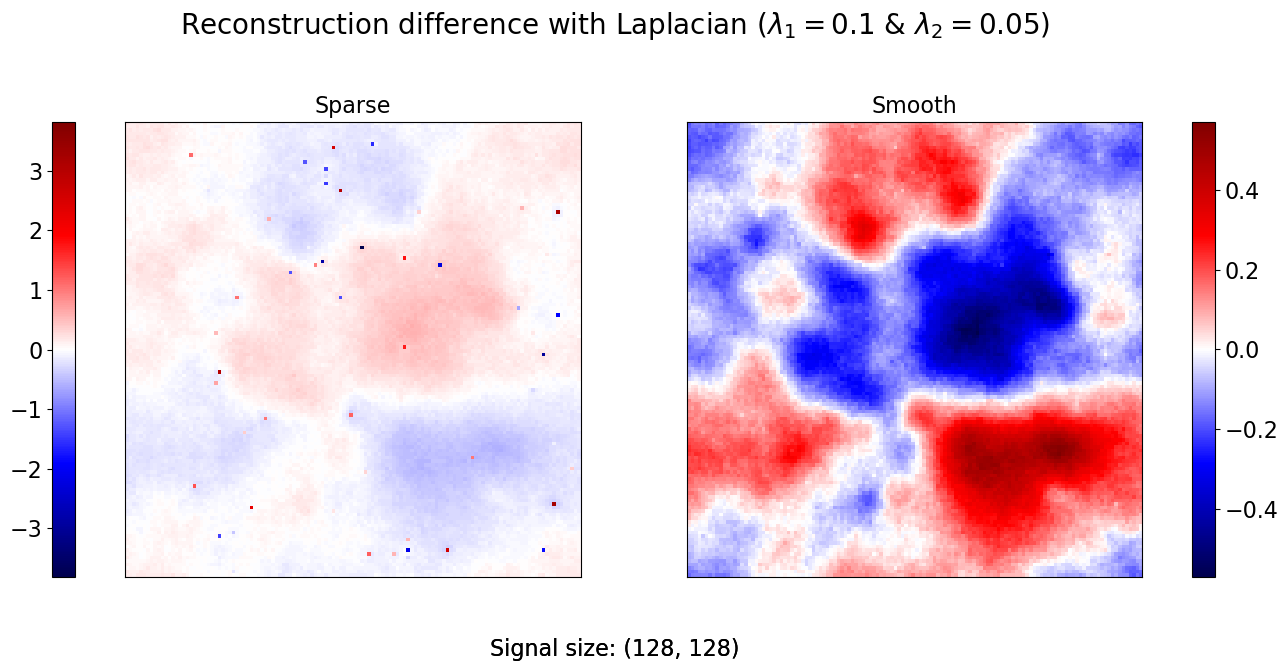

In [17]:
difference(N,
    laplacian,
    lambda1,
    lambda2,
    sparse_rcstr_coupled,
    sparse_rcstr_decoupled,
    smooth_rcstr_coupled,
    smooth_rcstr_decoupled);

Sparse signal analysis
Coupled
	Sparsity: 16381
	Almost sparsity: 9751
	Min value: -0.6090750313826765
	Max value: 0.6045013662762575

Decoupled
	Sparsity: 86
	Almost sparsity: 64
	Min value: -3.762767177448516
	Max value: 4.295742404059793

Source
	Sparsity: 67
	Almost sparsity: 65
	Min value: -5.968414133044941
	Max value: 5.606558481699221

L2 norm:
	Relative difference between the reconstructions: 1.091
	Relative difference between coupled and source: 1.365
	Relative difference between decoupled and source: 0.565
L1 norm:
	Relative difference between the reconstructions: 14.548
	Relative difference between coupled and source: 15.084
	Relative difference between decoupled and source: 0.635


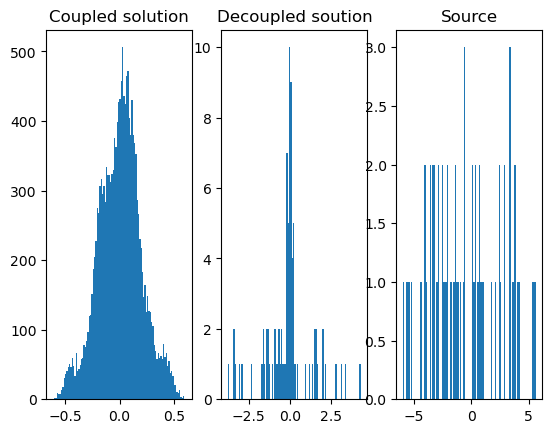

In [18]:
x1_source = sparse_signal.reshape(-1)

print("Sparse signal analysis")

for x1, t in zip([x1_coupled, x1_decoupled, x1_source], ['Coupled', 'Decoupled', 'Source']):
    print(t)
    print(f"\tSparsity: {np.count_nonzero(x1)}")
    print(f"\tAlmost sparsity: {(np.abs(x1)>1e-1).sum()}")
    print(f"\tMin value: {x1.min()}")
    print(f"\tMax value: {x1.max()}\n")

print("L2 norm:")
print(f"\tRelative difference between the reconstructions: "
    f"{np.linalg.norm(x1_decoupled - x1_coupled, 2)/np.linalg.norm(x1_source, 2):.3f}")
print(f"\tRelative difference between coupled and source: "
    f"{np.linalg.norm(x1_source - x1_coupled, 2)/np.linalg.norm(x1_source, 2):.3f}")
print(f"\tRelative difference between decoupled and source: "
    f"{np.linalg.norm(x1_decoupled - x1_source, 2)/np.linalg.norm(x1_source, 2):.3f}")

print("L1 norm:")
print(f"\tRelative difference between the reconstructions: "
    f"{np.linalg.norm(x1_decoupled - x1_coupled, 1)/np.linalg.norm(x1_source, 1):.3f}")
print(f"\tRelative difference between coupled and source: "
    f"{np.linalg.norm(x1_source - x1_coupled, 1)/np.linalg.norm(x1_source, 1):.3f}")
print(f"\tRelative difference between decoupled and source: "
    f"{np.linalg.norm(x1_decoupled - x1_source, 1)/np.linalg.norm(x1_source, 1):.3f}")

plt.figure()
plt.subplot(131)
plt.hist(x1_coupled[x1_coupled != 0], bins=100)
plt.title("Coupled solution")
plt.subplot(132)
plt.hist(x1_decoupled[x1_decoupled != 0], bins=100)
plt.title("Decoupled soution")
plt.subplot(133)
plt.hist(x1_source[x1_source != 0], bins=100)
plt.title("Source")
plt.show()

In [19]:
x2_source = smooth_signal.reshape(-1)

print("Smooth signal analysis")

for x2, t in zip([x2_coupled, x2_decoupled, x2_source], ['Coupled', 'Decoupled', 'Source']):
    print(t)
    print(f"\tMin value: {x2.min()}")
    print(f"\tMax value: {x2.max()}\n")

print("L2 norm:")
print(f"\tRelative difference between the reconstructions: "
    f"{np.linalg.norm(x2_decoupled - x2_coupled, 2)/np.linalg.norm(x2_source, 2):.3f}")
print(f"\tRelative difference between coupled and source: "
    f"{np.linalg.norm(x2_source - x2_coupled, 2)/np.linalg.norm(x2_source, 2):.3f}")
print(f"\tRelative difference between decoupled and source: "
    f"{np.linalg.norm(x2_decoupled - x2_source, 2)/np.linalg.norm(x2_source, 2):.3f}")

print("L1 norm:")
print(f"\tRelative difference between the reconstructions: "
    f"{np.linalg.norm(x2_decoupled - x2_coupled, 1)/np.linalg.norm(x2_source, 1):.3f}")
print(f"\tRelative difference between coupled and source: "
    f"{np.linalg.norm(x2_source - x2_coupled, 1)/np.linalg.norm(x2_source, 1):.3f}")
print(f"\tRelative difference between decoupled and source: "
    f"{np.linalg.norm(x2_decoupled - x2_source, 1)/np.linalg.norm(x2_source, 1):.3f}")

Smooth signal analysis
Coupled
	Min value: -0.6091034727611243
	Max value: 0.6045223058721141

Decoupled
	Min value: -1.1567836557781221
	Max value: 1.152152183117549

Source
	Min value: -1.368721795570836
	Max value: 2.0

L2 norm:
	Relative difference between the reconstructions: 0.410
	Relative difference between coupled and source: 0.707
	Relative difference between decoupled and source: 0.579
L1 norm:
	Relative difference between the reconstructions: 0.525
	Relative difference between coupled and source: 0.776
	Relative difference between decoupled and source: 0.747


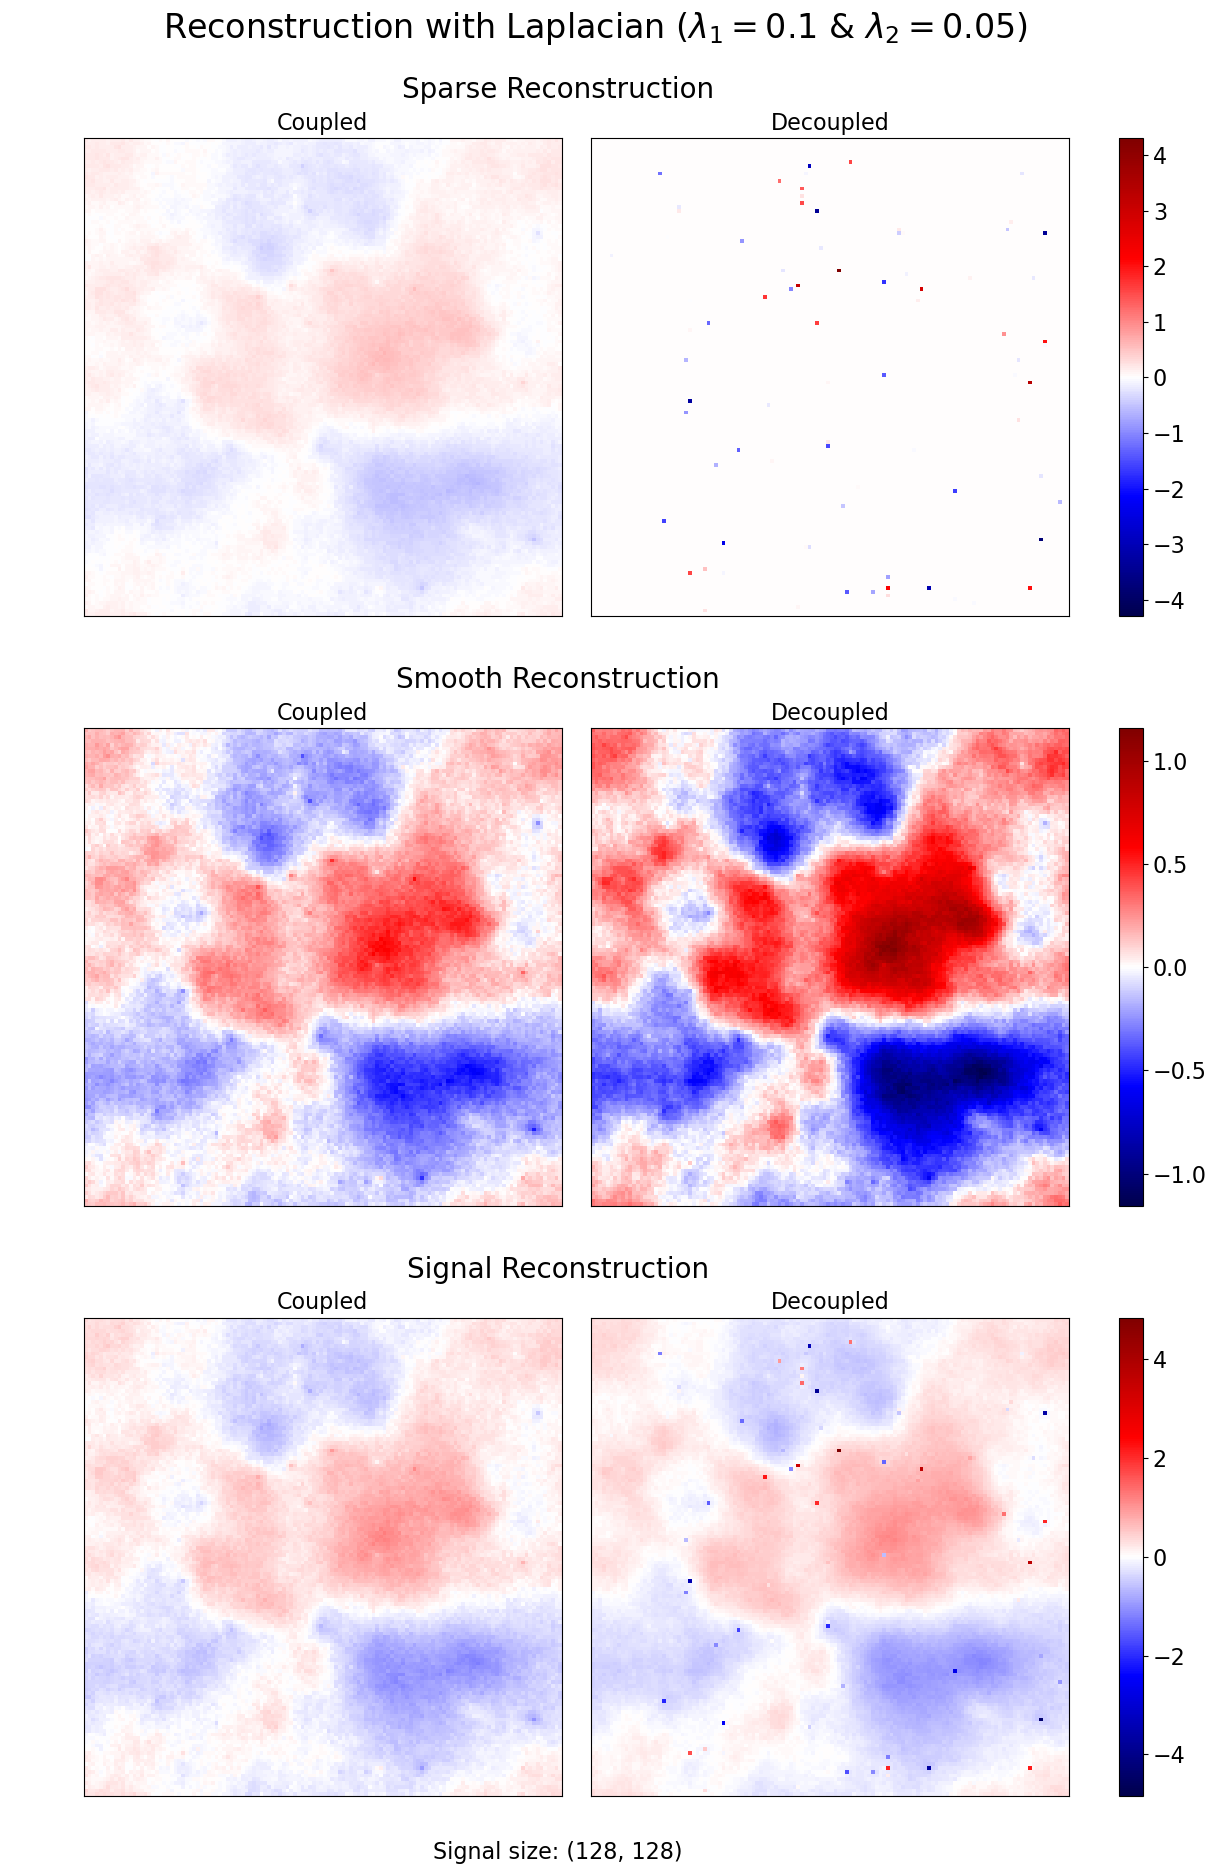

In [20]:
compare(
    N,
    laplacian,
    lambda1,
    lambda2,
    sparse_rcstr_coupled,
    sparse_rcstr_decoupled,
    smooth_rcstr_coupled,
    smooth_rcstr_decoupled,
    signal_rcstr_coupled,
    signal_rcstr_decoupled,
);

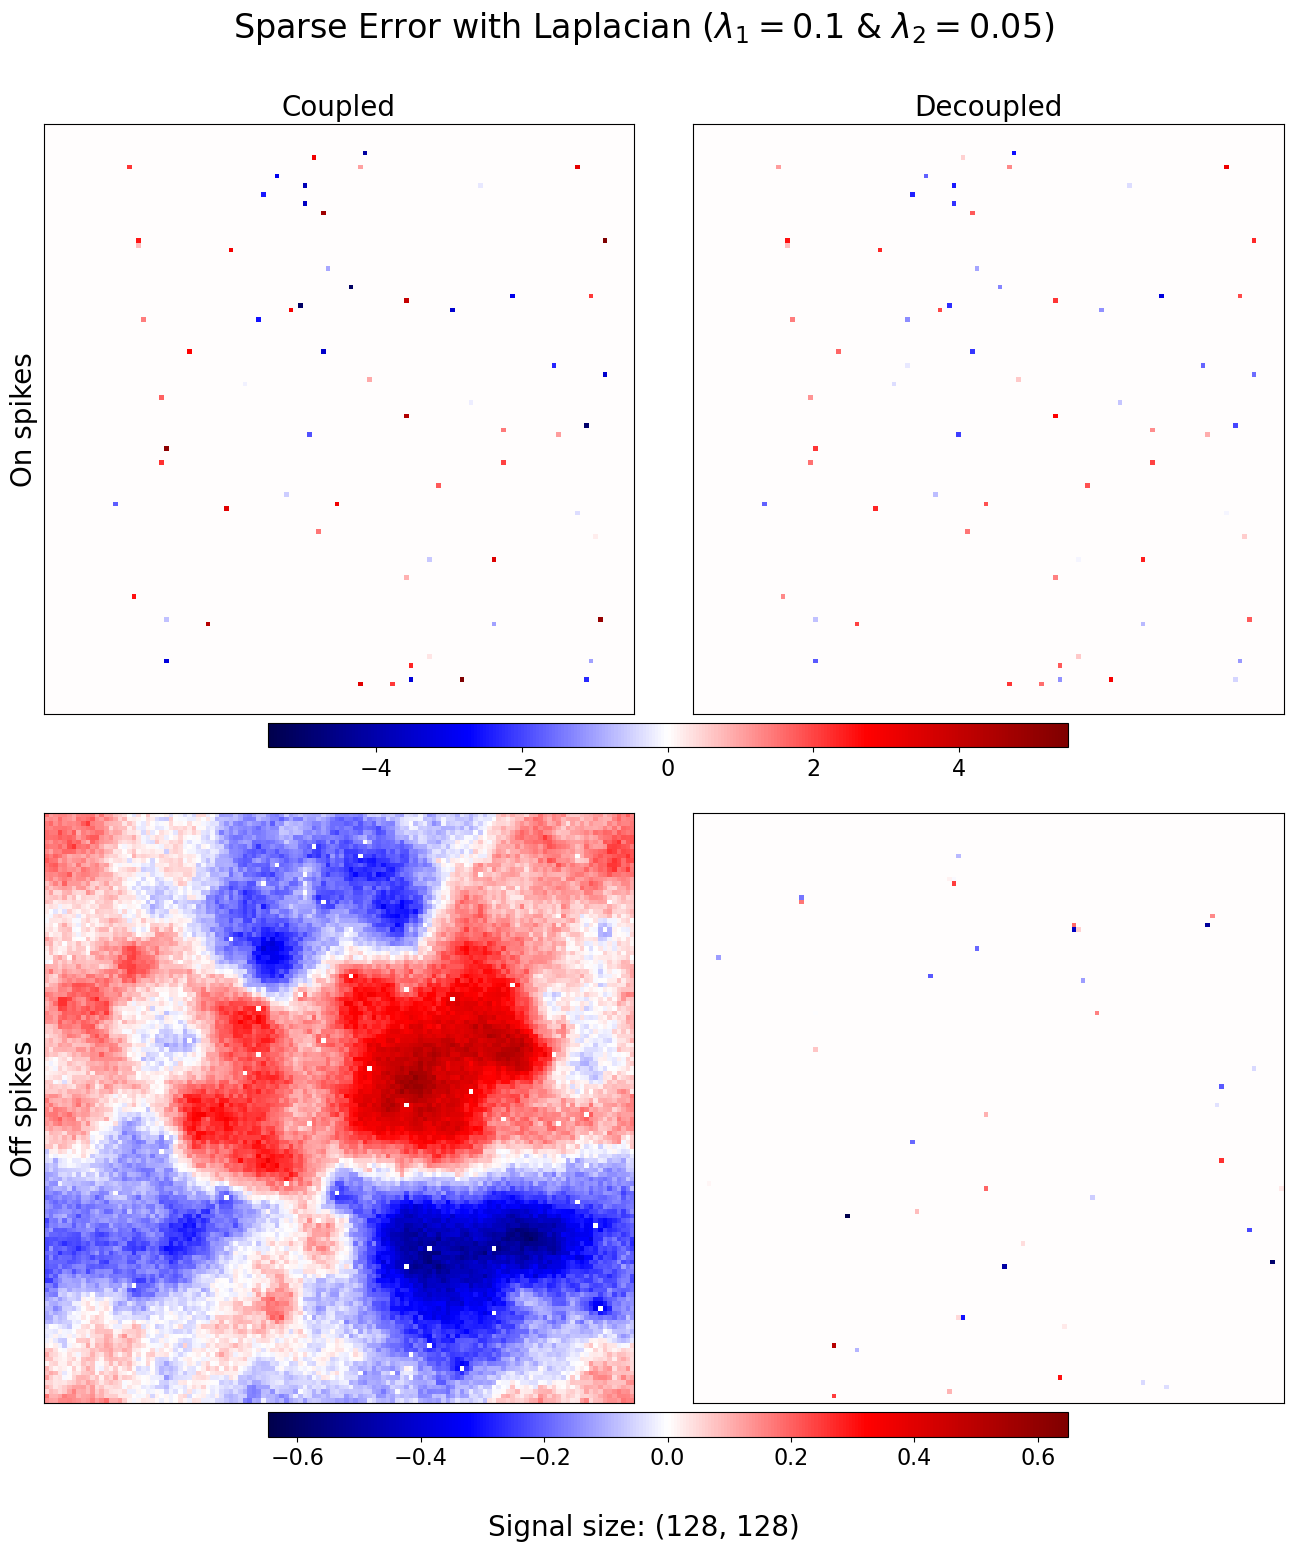

In [21]:
sparse_error(
    N,
    laplacian,
    lambda1,
    lambda2,
    sparse_signal,
    sparse_rcstr_coupled,
    sparse_rcstr_decoupled,
);

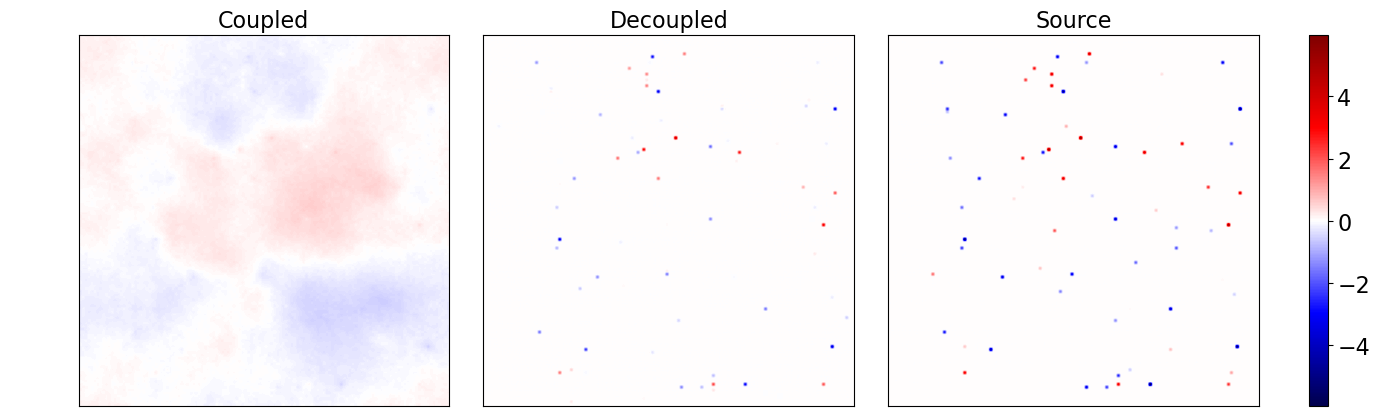

In [22]:
images = [sparse_rcstr_coupled, sparse_rcstr_decoupled, sparse_signal]
names = ['Coupled', 'Decoupled', 'Source']
title = None

f = plt.figure(figsize=(17, 5))
# Plot the 3 images contained in images side by side, with the same colormap. Put the colorbar on the right. Attribute the names cotained in the lst names.
axes = f.subplots(1, 3)
divnorm = colors.CenteredNorm(
    vcenter=0.0,
    halfrange=max([np.abs(im).max() for im in images]),
)
for j in range(3):
    im = axes[j].imshow(
        images[j],
        cmap="seismic",
        norm=divnorm,
    )
    axes[j].set_yticks([])
    axes[j].set_xticks([])
    divider = make_axes_locatable(axes[j])
    axes[j].set_title(names[j], fontsize=16)
    plt.subplots_adjust(wspace=0)
    if j == 2:
        cax = divider.append_axes(position="right", size="5%", pad=0.5)
        cbar = f.colorbar(im, cax=cax)
        cbar.ax.tick_params(labelsize=16)
    elif j == 0:
        cax = divider.append_axes(position="left", size="5%", pad=0.5)
        cax.axis("off")
    else:
        cax = divider.append_axes(position="left", size="2.5%", pad=0.25)
        cax.axis("off")
        cax = divider.append_axes(position="right", size="2.5%", pad=0.25)
        cax.axis("off")

if title:
    plt.suptitle(title)

plt.show()